# Calculate total Arctic sea ice extent: 
  
Katie Brennan  
December 2021  

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import time as timestamp 
import importlib

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

import run_forecast_model_data as rf

In [4]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [5]:
def load_sic_data(var, exp_setup):
    fdic = limkb.build_training_dic(exp_setup['valid_dsource'])

    Ptrunc = {}
    var_dict_gfdl_hist = {}
    ntims = len(exp_setup['lags'])
    print('Validation data: '+exp_setup['valid_dsource'])

    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

    X_var_gfdl_hist, var_dict_gfdl_hist = limkb.load_data(var, var_dict_gfdl_hist, fdic, 
                                                      remove_climo=exp_setup['remove_climo'], 
                                                      detrend=exp_setup['detrend'], verbose=verbose, 
                                                      tscut=int(exp_setup['nyears_startvalid']/12), 
                                                      tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])
    
    return  X_var_gfdl_hist, var_dict_gfdl_hist, fdic, tecut

In [6]:
def load_sie_data(var, fdic, exp_setup, tecut):
    var_dict_full_og = {}

    X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                      remove_climo=False, 
                                                      detrend=False, verbose=verbose, 
                                                      tscut=int(exp_setup['nyears_startvalid']/12), 
                                                      tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

    sie = np.where(X_var_full_og>=0.15,100,0)
    ndof = sie.shape[0]
    ntime = sie.shape[1]
    remove_climo = exp_setup['remove_climo']

    #Detrend: 
    x_var_dt = np.zeros((ndof,int(ntime/12),12))
    climo = np.zeros((ndof,12))
    x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
    for i in range(12):
        print('Working on month...'+str(i))
        y = x_var_3d[:,:,i]
        if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
            print('Found some nans in satellite data, going to fill with previous timestep...')
            inds = np.where(np.isnan(y))
            ind_int = int(inds[1].min()-1)
            fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
            var_nans_mask = np.where(np.isnan(y),np.nan,1)
            Y = np.where(np.isnan(y),fill,y)
        elif np.isnan(y).sum()>0: 
            print('Found with nans (not in satellite), going to fill with zeros...')
            var_nans_mask = np.where(np.isnan(y),np.nan,1)
            Y = np.where(np.isnan(y),0,y)
        else: 
            Y = y
    #                print('Y = '+ str(Y.shape))
        X = np.arange(0,int(ntime/12))
        [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                            remove_mn=remove_climo)
        if np.isnan(y).sum()>0:
            x_var_dt[:,:,i] = var_dt*var_nans_mask
        else: 
            x_var_dt[:,:,i] = var_dt
        climo[:,i] = intercept

    x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
    sie_anom_gfdl_hist = x_var_anom
    
    return sie_anom_gfdl_hist

In [7]:
def calc_tot_sia_sie(var, fdic, X_var_gfdl_hist, sie_anom_gfdl_hist, var_dict_gfdl_hist,dsource):
    
    full_names, areawt_name, month_names = limbuild.load_full_names(dsource)

    areacell_dict_all = {}
    areacell = {}
    areacell_dict = {}
    areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                           remove_climo=False, detrend=False, verbose=False, 
                                                           lat_cutoff=exp_setup['lat_cutoff'][var])

    units = areacell_dict_all[var][areawt_name[var]]['units']

    if 'km' in units:
        acell = areacell[var]
    elif 'centi' in units: 
        print('changing cellarea units from '+
              str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-10)
        units = 'km^2'
    else: 
        print('changing cellarea units from '+
              str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-6)
        units = 'km^2'

    nlon = int(var_dict_gfdl_hist[var]['var_ndof']/var_dict_gfdl_hist[var]['lat'].shape[0])

    tot_arc_sia_gfdl_hist_1850_2014 = statskb.calc_tot_si_checks(X_var_gfdl_hist,acell,units,
                                                                var_dict_gfdl_hist[var]['lat'],
                                                                nlon,lat_cutoff=0.0)
    tot_arc_sie_gfdl_hist_1850_2014 = statskb.calc_tot_si_checks(sie_anom_gfdl_hist,acell,units,
                                                                var_dict_gfdl_hist[var]['lat'],
                                                                nlon,lat_cutoff=0.0)
    
    return tot_arc_sia_gfdl_hist_1850_2014, tot_arc_sie_gfdl_hist_1850_2014

In [8]:
ntrunc= 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50

lat_cutoff_dict = {'tas':40,'psl':40,'zg':40,'tos':40,'sit':40,'sic':40}

limvars = ['tas','psl','zg','tos','sit','sic']
mo='all'

lags = [0,1,2,3,4,5,6,7,8]

train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cesm_lme'

tau = 1

exp_setup = {}
exp_setup['limvars'] = ['tas','psl','zg','tos','sit','sic']
exp_setup['lat_cutoff'] = lat_cutoff_dict
exp_setup['Weight']=True
exp_setup['remove_climo'] = True
exp_setup['detrend'] = True
exp_setup['nyr_train'] = None

yrend = 1650
#yrstart = 1056    # validation 1905-2005, 100 years of validation
yrstart = 1081  # validation 1930-2005, 75 years of validation 
#yrstart = 95  # validation 1915-2015, 75 years of validation 

# #LME settings (in sample): 
exp_setup['nyearsvalid'] = 1000
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

exp_setup['mo'] = mo
if 'all' in str(mo): 
    exp_setup['ind_month_trunc'] = False
else: 
    exp_setup['ind_month_trunc'] = True
exp_setup['tau'] = tau
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 
exp_setup['sic_separate'] = True
exp_setup['lags'] = lags
exp_setup['Insamp'] = False
exp_setup['step2_trunc'] = False
exp_setup['ntrunc'] = ntrunc 
exp_setup['nmodes_sic'] = nmodes_sic

verbose = True

In [9]:
var = 'sit'

## CESM LME 851-1850: 

In [10]:
X_var_train, var_dict_train, fdic_train, tecut_train = load_sic_data(var, exp_setup)

sie_anom_train = load_sie_data(var, fdic_train, exp_setup, tecut_train)

[tot_arc_sia_lme_851_1850, 
 tot_arc_sie_lme_851_1850] = calc_tot_sia_sie(var, fdic_train, X_var_train, 
                                              sie_anom_train, var_dict_train, dsource='')

Validation data: cesm_lme
Loading from sit
Loading from aIceData/LME/LIMs/sit_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 851 - 1850
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sat

Text(0.5, 1.0, 'CESM LME (851-1850)')

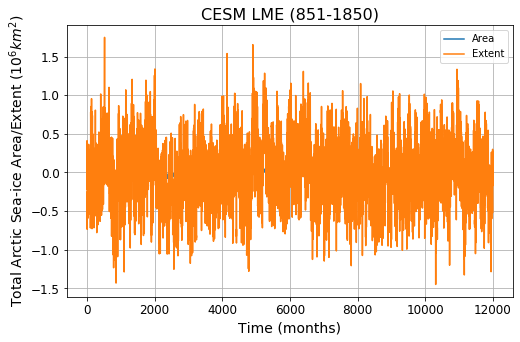

In [11]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_lme_851_1850/1e6, label='Area')
plt.plot(tot_arc_sie_lme_851_1850/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('CESM LME (851-1850)', fontsize=16)

### Load tos lat/lon data: 

In [12]:
_, var_dict_train_tos,_,_ = load_sic_data(var, exp_setup)

Validation data: cesm_lme
Loading from sit
Loading from aIceData/LME/LIMs/sit_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 851 - 1850
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sat

## CESM LME 1851-2005: 

In [13]:
exp_setup['nyearsvalid'] =155
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyearstot'] = 1155
exp_setup['nyears_startvalid'] = 1001*12

In [14]:
X_var_lme_hist, var_dict_lme_hist, fdic_lme_hist, tecut_lme_hist = load_sic_data(var, exp_setup)

sie_anom_lme_hist = load_sie_data(var, fdic_lme_hist, exp_setup, tecut_lme_hist)

[tot_arc_sia_lme_1851_2005, 
 tot_arc_sie_lme_1851_2005] = calc_tot_sia_sie(var, fdic_lme_hist, X_var_lme_hist, 
                                               sie_anom_lme_hist, var_dict_lme_hist, dsource='')

Validation data: cesm_lme
Loading from sit
Loading from aIceData/LME/LIMs/sit_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 1851 - 2005
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sa

Text(0.5, 1.0, 'CESM LME (1851-2005)')

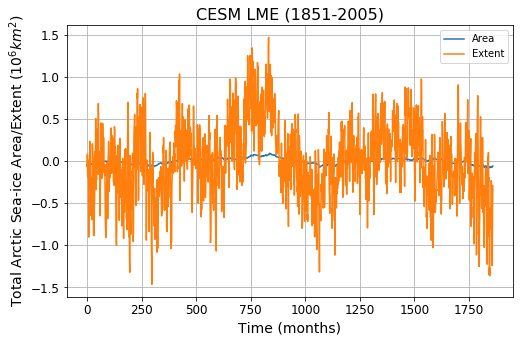

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_lme_1851_2005/1e6, label='Area')
plt.plot(tot_arc_sie_lme_1851_2005/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('CESM LME (1851-2005)', fontsize=16)

## CCSM4 Last Millennium (850-1850):

In [16]:
train_dsource = 'cesm_le'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'ccsm4_lm_regridlme'

In [17]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 1000
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [18]:
X_var_ccsm4_lm, var_dict_ccsm4_lm, fdic_ccsm4_lm, tecut_ccsm4_lm = load_sic_data(var, exp_setup)

sie_anom_ccsm4_lm = load_sie_data(var, fdic_ccsm4_lm, exp_setup, tecut_ccsm4_lm)

[tot_arc_sia_ccsm4_lm, 
 tot_arc_sie_ccsm4_lm] = calc_tot_sia_sie(var, fdic_ccsm4_lm, X_var_ccsm4_lm, 
                                          sie_anom_ccsm4_lm, var_dict_ccsm4_lm, dsource='')

Validation data: ccsm4_lm_regridlme
Loading from sit
Loading from nium/sit_sfc_OImon_CCSM4_past1000_regridlme_085001-185012.nc
time dimension: 851 - 1850
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (

Text(0.5, 1.0, 'CCSM4 LM (850-1850)')

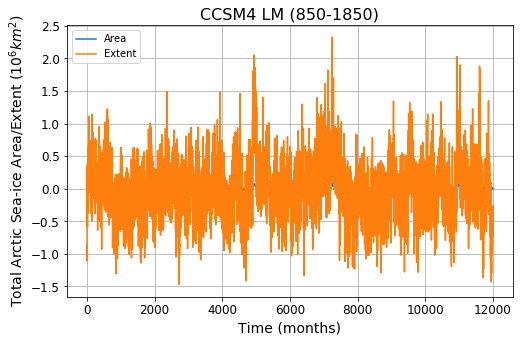

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_ccsm4_lm/1e6, label='Area')
plt.plot(tot_arc_sie_ccsm4_lm/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('CCSM4 LM (850-1850)', fontsize=16)

## MPI Last Millennium (850-1850) - MPI grid

In [20]:
train_dsource = 'cesm_le'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'mpi_lm_kb'

In [21]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 1000
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [22]:
X_var_mpi_lm2, var_dict_mpi_lm2, fdic_mpi_lm2, tecut_mpi_lm2 = load_sic_data(var, exp_setup)

sie_anom_mpi_lm2= load_sie_data(var, fdic_mpi_lm2, exp_setup, tecut_mpi_lm2)

[tot_arc_sia_mpi_lm2, 
 tot_arc_sie_mpi_lm2] = calc_tot_sia_sie(var, fdic_mpi_lm2, X_var_mpi_lm2, 
                                          sie_anom_mpi_lm2, var_dict_mpi_lm2, dsource='')

Validation data: mpi_lm_kb
Loading from sit
Loading from ceData/MPI/sit_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 851 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 62.23346519470215 seconds
-----------------------------------------------------
Loading from sit
Loading from ceData/MPI/sit_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 851 - 1849
latitude cutoff detected: 40
-----------------------------------------------------
completed in 1.9855568408966064 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on 

Text(0.5, 1.0, 'MPI LM, native grid (850-1850)')

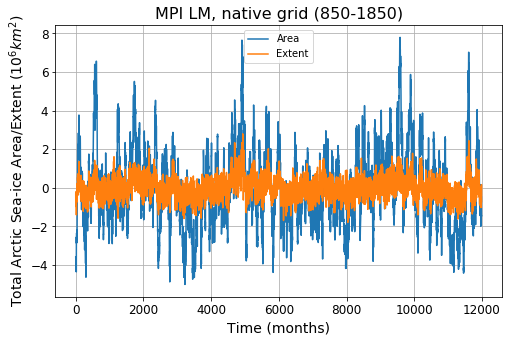

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_mpi_lm2/1e6, label='Area')
plt.plot(tot_arc_sie_mpi_lm2/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('MPI LM, native grid (850-1850)', fontsize=16)

## MPI Last Millennium (850-1850) - LME grid

In [24]:
train_dsource = 'cesm_le'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'mpi_lm_regridlme'

In [25]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 1000
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [26]:
X_var_mpi_lm, var_dict_mpi_lm, fdic_mpi_lm, tecut_mpi_lm = load_sic_data(var, exp_setup)

sie_anom_mpi_lm= load_sie_data(var, fdic_mpi_lm, exp_setup, tecut_mpi_lm)

[tot_arc_sia_mpi_lm, 
 tot_arc_sie_mpi_lm] = calc_tot_sia_sie(var, fdic_mpi_lm, X_var_mpi_lm, 
                                        sie_anom_mpi_lm, var_dict_mpi_lm, dsource='')

Validation data: mpi_lm_regridlme
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 851 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 49.766655921936035 seconds
-----------------------------------------------------
Loading from sit
Loading from /sit_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 851 - 1849
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.2790064811706543 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Wor

Text(0.5, 1.0, 'MPI LM, LMEgrid (850-1850)')

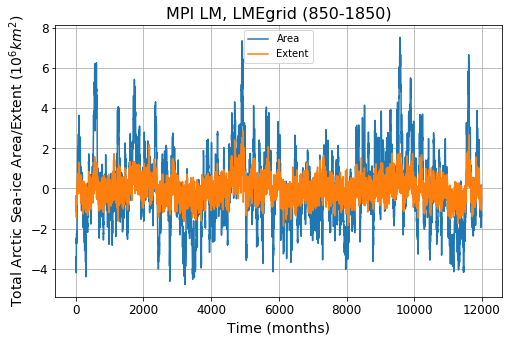

In [27]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_mpi_lm/1e6, label='Area')
plt.plot(tot_arc_sie_mpi_lm/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('MPI LM, LMEgrid (850-1850)', fontsize=16)

## CESM LE 2006-2100: 

In [28]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cesm_le'

In [29]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 93
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [30]:
X_var_le, var_dict_le, fdic_le, tecut_le = load_sic_data(var, exp_setup)

sie_anom_le= load_sie_data(var, fdic_le, exp_setup, tecut_le)

[tot_arc_sia_le_2006_2100, 
 tot_arc_sie_le_2006_2100] = calc_tot_sia_sie(var, fdic_le, X_var_le, 
                                              sie_anom_le, var_dict_le,dsource='')

Validation data: cesm_le
Loading from sit
Loading from ments/SeaIceData/CESM_LE/sit_CESM_LE_002_nh_200601-210012.nc
time dimension: 2007 - 2100
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sat

In [31]:
start = np.arange(0,93-50,10)
chunk_mn = np.zeros((len(start)))

for i,s in enumerate(start):
    chunk_mn[i] = np.nanmean(tot_arc_sia_le_2006_2100[s*12:(s+50)*12])
    print(chunk_mn[i]/1e6)


-0.001387683850583064
-0.007533718504176488
-0.011815422631617252
-0.008845699273724706
-0.003240565229633264


Text(0.5, 1.0, 'CESM LE (2006-2100)')

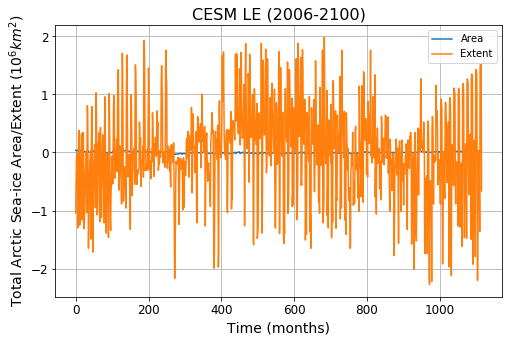

In [32]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_le_2006_2100/1e6, label='Area')
plt.plot(tot_arc_sie_le_2006_2100/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('CESM LE (2006-2100)', fontsize=16)

## CMIP6 CESM2 Historical Simulation: 

In [33]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_cesm2_hist'

In [34]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [35]:
X_var_cesm2_hist, var_dict_cesm2_hist, fdic_cesm2_hist, tecut_cesm2_hist = load_sic_data(var, exp_setup)

sie_anom_cesm2_hist= load_sie_data(var, fdic_cesm2_hist, exp_setup, tecut_cesm2_hist)

[tot_arc_sia_cesm2_hist_1850_2014, 
 tot_arc_sie_cesm2_hist_1850_2014] = calc_tot_sia_sie(var, fdic_cesm2_hist, X_var_cesm2_hist, 
                                                      sie_anom_cesm2_hist, var_dict_cesm2_hist,dsource='')

Validation data: cmip6_cesm2_hist
Loading from sit
Loading from ical/sit_SImon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (n

Text(0.5, 1.0, 'CESM2 Historical (1850-2014)')

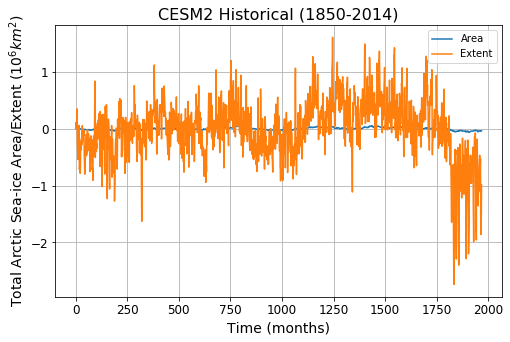

In [36]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_cesm2_hist_1850_2014/1e6, label='Area')
plt.plot(tot_arc_sie_cesm2_hist_1850_2014/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('CESM2 Historical (1850-2014)', fontsize=16)

## CMIP6 MPI Historical Simulation: 

In [37]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_mpi_hist_regridlme'

In [38]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [39]:
X_var_mpi_hist, var_dict_mpi_hist, fdic_mpi_hist, tecut_mpi_hist = load_sic_data(var, exp_setup)

sie_anom_mpi_hist= load_sie_data(var, fdic_mpi_hist, exp_setup, tecut_mpi_hist)

[tot_arc_sia_mpi_hist_1850_2014, 
 tot_arc_sie_mpi_hist_1850_2014] = calc_tot_sia_sie(var, fdic_mpi_hist, X_var_mpi_hist, 
                                                      sie_anom_mpi_hist, var_dict_mpi_hist,dsource='')

Validation data: cmip6_mpi_hist_regridlme
Loading from sit
Loading from MPI-ESM1-2-LR_historical_r1i1p1f1_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with

Text(0.5, 1.0, 'MPI Historical (1850-2014)')

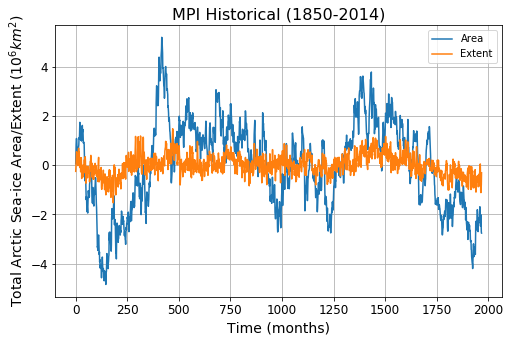

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_mpi_hist_1850_2014/1e6, label='Area')
plt.plot(tot_arc_sie_mpi_hist_1850_2014/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('MPI Historical (1850-2014)', fontsize=16)

## CMIP6 GFDL Historical simulation: 

In [41]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_gfdl_hist_regridlme'

In [42]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [43]:
X_var_gfdl_hist, var_dict_gfdl_hist, fdic_gfdl_hist, tecut_gfdl_hist = load_sic_data(var, exp_setup)

sie_anom_gfdl_hist= load_sie_data(var, fdic_gfdl_hist, exp_setup, tecut_gfdl_hist)

[tot_arc_sia_gfdl_hist_1850_2014, 
 tot_arc_sie_gfdl_hist_1850_2014] = calc_tot_sia_sie(var, fdic_gfdl_hist, X_var_gfdl_hist, 
                                                     sie_anom_gfdl_hist, var_dict_gfdl_hist,dsource='')

Validation data: cmip6_gfdl_hist_regridlme
Loading from sit
Loading from mon_GFDL-ESM4_historical_r1i1p1f1_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found wit

Text(0.5, 1.0, 'GFDL Historical (1850-2014)')

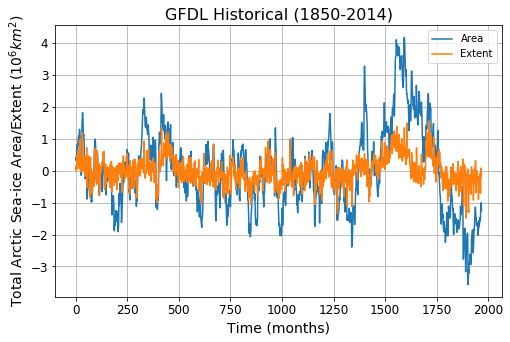

In [44]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_gfdl_hist_1850_2014/1e6, label='Area')
plt.plot(tot_arc_sie_gfdl_hist_1850_2014/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('GFDL Historical (1850-2014)', fontsize=16)

In [45]:
X_var_gfdl_hist.shape

(30720, 1968)

## CMIP6 CanESM5 Historical simulation: 

In [46]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_CanESM_hist_regridlme'

In [47]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [48]:
X_var_canESM_hist, var_dict_canESM_hist, fdic_canESM_hist, tecut_canESM_hist = load_sic_data(var, exp_setup)

sie_anom_canESM_hist= load_sie_data(var, fdic_canESM_hist, exp_setup, tecut_canESM_hist)

[tot_arc_sia_canESM_hist_1850_2014, 
 tot_arc_sie_canESM_hist_1850_2014] = calc_tot_sia_sie(var, fdic_canESM_hist, X_var_canESM_hist, 
                                                     sie_anom_canESM_hist, var_dict_canESM_hist,dsource='')

Validation data: cmip6_CanESM_hist_regridlme
Loading from sit
Loading from SImon_CanESM5_historical_r1i1p2f1_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found w

Text(0.5, 1.0, 'CanESM5 Historical (1850-2014)')

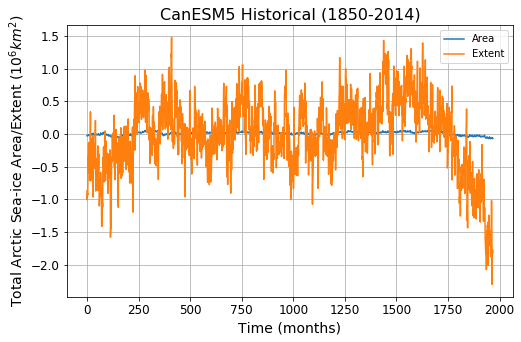

In [49]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_canESM_hist_1850_2014/1e6, label='Area')
plt.plot(tot_arc_sie_canESM_hist_1850_2014/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('CanESM5 Historical (1850-2014)', fontsize=16)

## CMIP6 HadGEM3 Historical simulation: 

In [50]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_HadGEM3_hist_regridlme'

In [51]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [52]:
X_var_hadGEM3_hist, var_dict_hadGEM3_hist, fdic_hadGEM3_hist, tecut_hadGEM3_hist = load_sic_data(var, exp_setup)

sie_anom_hadGEM3_hist= load_sie_data(var, fdic_hadGEM3_hist, exp_setup, tecut_hadGEM3_hist)

[tot_arc_sia_hadGEM3_hist_1850_2014, 
 tot_arc_sie_hadGEM3_hist_1850_2014] = calc_tot_sia_sie(var, fdic_hadGEM3_hist, X_var_hadGEM3_hist, 
                                                     sie_anom_hadGEM3_hist, var_dict_hadGEM3_hist,dsource='')

Validation data: cmip6_HadGEM3_hist_regridlme
Loading from sit
Loading from dGEM3-GC31-LL_historical_r1i1p1f3_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found 

Text(0.5, 1.0, 'HadGEM3 Historical (1850-2014)')

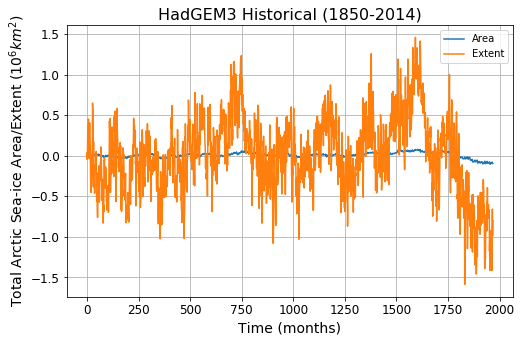

In [53]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_hadGEM3_hist_1850_2014/1e6, label='Area')
plt.plot(tot_arc_sie_hadGEM3_hist_1850_2014/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('HadGEM3 Historical (1850-2014)', fontsize=16)

## Satellite data: 

In [54]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'satellite_regridlme'

In [55]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 36
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [56]:
X_var_sat, var_dict_sat, fdic_sat, tecut_sat = load_sic_data(var, exp_setup)

sie_anom_sat= load_sie_data(var, fdic_sat, exp_setup, tecut_sat)

[tot_arc_sia_sat_1980_2016, 
 tot_arc_sie_sat_1980_2016] = calc_tot_sia_sie(var, fdic_sat, X_var_sat, 
                                               sie_anom_sat, var_dict_sat,dsource='')

Validation data: satellite_regridlme
Loading from sit


TypeError: 'NoneType' object is not subscriptable

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_sat_1980_2016/1e6, label='Area')
plt.plot(tot_arc_sie_sat_1980_2016/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('Satellite (1980-2016)', fontsize=16)

## Reanlaysis data: 

In [57]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'era5_regridlme'

In [58]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 41
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [59]:
X_var_era5, var_dict_era5, fdic_era5, tecut_era5 = load_sic_data(var, exp_setup)

sie_anom_era5= load_sie_data(var, fdic_era5, exp_setup, tecut_era5)

[tot_arc_sia_era5_1980_2020, 
 tot_arc_sie_era5_1980_2020] = calc_tot_sia_sie(var, fdic_era5, X_var_era5, 
                                               sie_anom_era5, var_dict_era5,dsource='')

Validation data: era5_regridlme
Loading from sit


TypeError: 'NoneType' object is not subscriptable

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_era5_1980_2020/1e6, label='Area')
plt.plot(tot_arc_sie_era5_1980_2020/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('ERA5 (1980-2020)', fontsize=16)

## Multimodel 1: 

For multimodel training datasets, pre-detrended and means removed before concating models together so can't calculate total Arctic sea ice extent. Thus, sie value below is erroneous. 

In [74]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon'

In [75]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 780
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 780

In [99]:
X_var_multimod1, var_dict_multimod1, fdic_multimod1, tecut_multimod1 = load_sic_data(var, exp_setup)

sie_anom_multimod1= load_sie_data(var, fdic_multimod1, exp_setup, tecut_multimod1)

[tot_arc_sia_multimod1_1850_2473, 
 tot_arc_sie_multimod1_1850_2473] = calc_tot_sia_sie(var, fdic_multimod1, X_var_multimod1, 
                                                     sie_anom_multimod1, var_dict_multimod1,'Amon')

Validation data: multimod_MPI_GFDL_HadGEM3_CanESM_hist_Amon
Loading from sic
Loading from ach_historical_detrended_latcut40_regridlme_185001-247312.nc
time dimension: 1851 - 2473
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on mo

Text(0.5, 1.0, 'Multimodel (MPI,GFDL,HadGEM3,CanESM historical))')

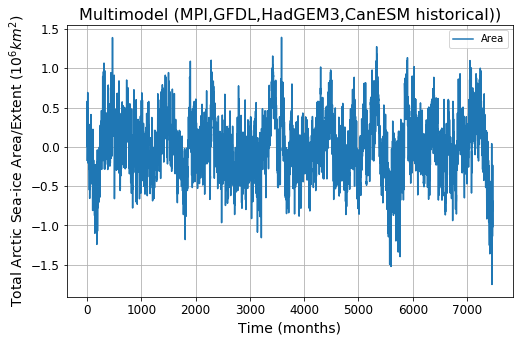

In [100]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_multimod1_1850_2473/1e6, label='Area')
#plt.plot(tot_arc_sie_multimod1_1850_2473/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('Multimodel (MPI,GFDL,HadGEM3,CanESM historical))', fontsize=16)

## Multimodel 2: 

In [101]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'multimod_CESM1_MPI_GFDL_HadGEM3_CanESM_hist_Amon'

In [102]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 624
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 624

In [103]:
X_var_multimod2.shape, sie_anom_multimod2.shape

((3888, 7488), (3888, 7488))

In [104]:
X_var_multimod2, var_dict_multimod2, fdic_multimod2, tecut_multimod2 = load_sic_data(var, exp_setup)

sie_anom_multimod2= load_sie_data(var, fdic_multimod2, exp_setup, tecut_multimod2)

[tot_arc_sia_multimod2_1850_2629, 
 tot_arc_sie_multimod2_1850_2629] = calc_tot_sia_sie(var, fdic_multimod2, X_var_multimod2, 
                                                     sie_anom_multimod2, var_dict_multimod2,'Amon')

Validation data: multimod_CESM1_MPI_GFDL_HadGEM3_CanESM_hist_Amon
Loading from sic
Loading from ach_historical_detrended_latcut40_regridlme_185001-262912.nc
time dimension: 1851 - 2474
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working

Text(0.5, 1.0, 'Multimodel (CESM1,MPI,GFDL,HadGEM3,CanESM historical))')

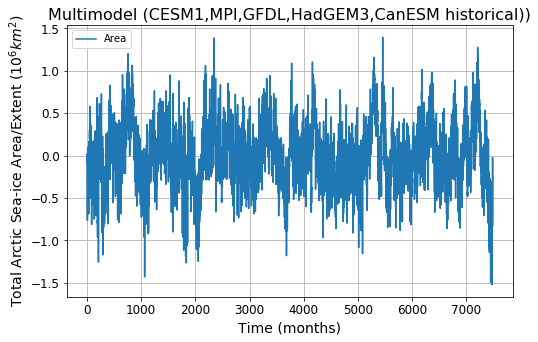

In [105]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_multimod2_1850_2629/1e6, label='Area')
#plt.plot(tot_arc_sie_multimod2_1850_2629/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('Multimodel (CESM1,MPI,GFDL,HadGEM3,CanESM historical))', fontsize=16)

## Spatial variance : 

In [60]:
train_mnstate = np.reshape(np.var(X_var_train[:,0:800*12],axis=1),(96,320))
# era5_mnstate = np.reshape(np.var(X_var_era5*100,axis=1),(96,320))
# sat_mnstate = np.reshape(np.nanvar(X_var_sat*100,axis=1),(96,320))

le_mnstate = np.reshape(np.var(X_var_le[:,0:50*12],axis=1),(96,320))

lme1_mnstate = np.reshape(np.var(X_var_lme_hist[:,12:50*12],axis=1),(96,320))
lme2_mnstate = np.reshape(np.var(X_var_lme_hist[:,51*12:100*12],axis=1),(96,320))
lme3_mnstate = np.reshape(np.var(X_var_lme_hist[:,101*12:155*12],axis=1),(96,320))

ccsm4_lm_mnstate = np.reshape(np.var(X_var_ccsm4_lm,axis=1),(96,320))

mpi_lm1_mnstate = np.reshape(np.var(X_var_mpi_lm[:,0:200],axis=1),(96,320))
mpi_lm2_mnstate = np.reshape(np.var(X_var_mpi_lm[:,200:400],axis=1),(96,320))
mpi_lm3_mnstate = np.reshape(np.var(X_var_mpi_lm[:,400:600],axis=1),(96,320))
mpi_lm_mnstate = np.reshape(np.var(X_var_mpi_lm,axis=1),(96,320))
#mpi_lm_mnstate2 = np.reshape(np.var(X_var_mpi_lm2,axis=1),(96,320))

cesm2_hist1_mnstate = np.reshape(np.var(X_var_cesm2_hist[:,12:50*12],axis=1),(96,320))
cesm2_hist2_mnstate = np.reshape(np.var(X_var_cesm2_hist[:,51*12:100*12],axis=1),(96,320))
cesm2_hist3_mnstate = np.reshape(np.var(X_var_cesm2_hist[:,101*12:164*12],axis=1),(96,320))
cesm2_hist_mnstate = np.reshape(np.var(X_var_cesm2_hist,axis=1),(96,320))

mpi_hist1_mnstate = np.reshape(np.var(X_var_mpi_hist[:,12:50*12],axis=1),(96,320))
mpi_hist2_mnstate = np.reshape(np.var(X_var_mpi_hist[:,51*12:100*12],axis=1),(96,320))
mpi_hist3_mnstate = np.reshape(np.var(X_var_mpi_hist[:,101*12:164*12],axis=1),(96,320))
mpi_hist_mnstate = np.reshape(np.var(X_var_mpi_hist,axis=1),(96,320))

gfdl_hist1_mnstate = np.reshape(np.var(X_var_gfdl_hist[:,12:50*12],axis=1),(96,320))
gfdl_hist2_mnstate = np.reshape(np.var(X_var_gfdl_hist[:,51*12:100*12],axis=1),(96,320))
gfdl_hist3_mnstate = np.reshape(np.var(X_var_gfdl_hist[:,101*12:164*12],axis=1),(96,320))
gfdl_hist_mnstate = np.reshape(np.var(X_var_gfdl_hist,axis=1),(96,320))

canESM_hist1_mnstate = np.reshape(np.var(X_var_canESM_hist[:,12:50*12],axis=1),(96,320))
canESM_hist2_mnstate = np.reshape(np.var(X_var_canESM_hist[:,51*12:100*12],axis=1),(96,320))
canESM_hist3_mnstate = np.reshape(np.var(X_var_canESM_hist[:,101*12:164*12],axis=1),(96,320))
canESM_hist_mnstate = np.reshape(np.var(X_var_canESM_hist,axis=1),(96,320))

hadGEM3_hist1_mnstate = np.reshape(np.var(X_var_hadGEM3_hist[:,12:50*12],axis=1),(96,320))
hadGEM3_hist2_mnstate = np.reshape(np.var(X_var_hadGEM3_hist[:,51*12:100*12],axis=1),(96,320))
hadGEM3_hist3_mnstate = np.reshape(np.var(X_var_hadGEM3_hist[:,101*12:164*12],axis=1),(96,320))
hadGEM3_hist_mnstate = np.reshape(np.var(X_var_hadGEM3_hist,axis=1),(96,320))

In [63]:
multimod1_hist_mnstate = np.reshape(np.var(X_var_multimod1,axis=1),(27,144))
multimod2_hist_mnstate = np.reshape(np.var(X_var_multimod2,axis=1),(27,144))

NameError: name 'X_var_multimod1' is not defined

In [87]:
# ccsm4_lm_mnstate = np.reshape(np.var(X_var_ccsm4_lm,axis=1),(96,320))
# mpi_lm_mnstate = np.reshape(np.var(X_var_mpi_lm,axis=1),(96,320))
# scor_train_mpi_lm = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(mpi_lm_mnstate.flatten()))[0,1]
# scor_train_ccsm4_lm = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(ccsm4_lm_mnstate.flatten()))[0,1]

ccsm4_mnstate = {}
scor_train_ccsm4 = {}

mpi_lm_all_mnstate = {}
scor_train_mpi_lm_all = {}

startyr_list = [1,100,200,300,400,500,600,700,800,900]
land_mask = np.where(np.logical_not(np.isfinite(train_mnstate)),np.nan,1)

for i,startyr in enumerate(startyr_list):
    ccsm4_mnstate[startyr] = np.reshape(np.var(X_var_ccsm4_lm[:,startyr:startyr+99],axis=1),(96,320))*land_mask
    scor_train_ccsm4[startyr] = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                            np.nan_to_num(ccsm4_mnstate[startyr].flatten()))[0,1]
    
    mpi_lm_all_mnstate[startyr] = np.reshape(np.var(X_var_mpi_lm[:,startyr:startyr+99],axis=1),(96,320))*land_mask
    scor_train_mpi_lm_all[startyr] = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                                 np.nan_to_num(mpi_lm_all_mnstate[startyr].flatten()))[0,1]

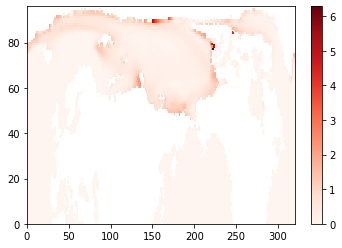

In [97]:
plt.pcolormesh(ccsm4_mnstate[1],cmap='Reds')
plt.colorbar()

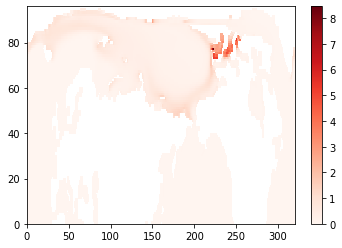

In [99]:
plt.pcolormesh(train_mnstate,cmap='Reds')
plt.colorbar()

In [91]:
scor_train_le = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num((le_mnstate*land_mask).flatten()))[0,1]
# scor_train_era5 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
# scor_era5_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
# scor_train_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]

# scor_lme3_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]
# scor_le_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
# scor_cesm2_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]
# scor_gfdl_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]
# scor_mpi_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]
# scor_ccsm4lm_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(ccsm4_lm_mnstate.flatten()))[0,1]
# scor_mpilm_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(mpi_lm_mnstate.flatten()))[0,1]

# scor_cesm2_era5 = np.corrcoef(np.nan_to_num(era5_mnstate.flatten()),np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]
# scor_gfdl_era5 = np.corrcoef(np.nan_to_num(era5_mnstate.flatten()),np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]
# scor_mpi_era5 = np.corrcoef(np.nan_to_num(era5_mnstate.flatten()),np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]

scor_train_ccsm4_lm = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num((ccsm4_lm_mnstate*land_mask).flatten()))[0,1]
scor_train_mpi_lm = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num((mpi_lm_mnstate*land_mask).flatten()))[0,1]

scor_train_lme1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num((lme1_mnstate*land_mask).flatten()))[0,1]
scor_train_lme2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num((lme2_mnstate*land_mask).flatten()))[0,1]
scor_train_lme3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num((lme3_mnstate*land_mask).flatten()))[0,1]

scor_train_cesm2_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((cesm2_hist1_mnstate*land_mask).flatten()))[0,1]
scor_train_cesm2_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((cesm2_hist2_mnstate*land_mask).flatten()))[0,1]
scor_train_cesm2_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((cesm2_hist3_mnstate*land_mask).flatten()))[0,1]
scor_train_cesm2_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((cesm2_hist_mnstate*land_mask).flatten()))[0,1]

scor_train_gfdl_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((gfdl_hist1_mnstate*land_mask).flatten()))[0,1]
scor_train_gfdl_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((gfdl_hist2_mnstate*land_mask).flatten()))[0,1]
scor_train_gfdl_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((gfdl_hist3_mnstate*land_mask).flatten()))[0,1]
scor_train_gfdl_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((gfdl_hist_mnstate*land_mask).flatten()))[0,1]

scor_train_mpi_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((mpi_hist1_mnstate*land_mask).flatten()))[0,1]
scor_train_mpi_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((mpi_hist2_mnstate*land_mask).flatten()))[0,1]
scor_train_mpi_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((mpi_hist3_mnstate*land_mask).flatten()))[0,1]
scor_train_mpi_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((mpi_hist_mnstate*land_mask).flatten()))[0,1]

scor_train_canESM_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((canESM_hist1_mnstate*land_mask).flatten()))[0,1]
scor_train_canESM_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((canESM_hist2_mnstate*land_mask).flatten()))[0,1]
scor_train_canESM_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((canESM_hist3_mnstate*land_mask).flatten()))[0,1]
scor_train_canESM_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((canESM_hist_mnstate*land_mask).flatten()))[0,1]

scor_train_hadGEM3_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((hadGEM3_hist1_mnstate*land_mask).flatten()))[0,1]
scor_train_hadGEM3_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((hadGEM3_hist2_mnstate*land_mask).flatten()))[0,1]
scor_train_hadGEM3_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((hadGEM3_hist3_mnstate*land_mask).flatten()))[0,1]
scor_train_hadGEM3_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num((hadGEM3_hist_mnstate*land_mask).flatten()))[0,1]

In [92]:
spatial_correlation = {}

spatial_correlation['scor_train_le'] = scor_train_le
# spatial_correlation['scor_train_era5'] = scor_train_era5
# spatial_correlation['scor_train_sat'] = scor_train_sat

# spatial_correlation['scor_lme3_sat'] = scor_lme3_sat
# spatial_correlation['scor_le_sat'] = scor_le_sat
# spatial_correlation['scor_cesm2_sat'] = scor_cesm2_sat
# spatial_correlation['scor_gfdl_sat'] = scor_gfdl_sat
# spatial_correlation['scor_mpi_sat'] = scor_mpi_sat
# spatial_correlation['scor_mpilm_sat'] = scor_mpilm_sat
# spatial_correlation['scor_ccsm4lm_sat'] = scor_ccsm4lm_sat

spatial_correlation['scor_train_mpi_lm'] = scor_train_mpi_lm
spatial_correlation['scor_train_mpi_lm_all'] = scor_train_mpi_lm_all
spatial_correlation['scor_train_ccsm4_lm'] = scor_train_ccsm4_lm
spatial_correlation['scor_train_ccsm4_lm_all'] = scor_train_ccsm4

spatial_correlation['scor_train_lme1'] = scor_train_lme1
spatial_correlation['scor_train_lme2'] = scor_train_lme2
spatial_correlation['scor_train_lme3'] = scor_train_lme3

spatial_correlation['scor_train_cesm2_hist1'] = scor_train_cesm2_hist1
spatial_correlation['scor_train_cesm2_hist2'] = scor_train_cesm2_hist2
spatial_correlation['scor_train_cesm2_hist3'] = scor_train_cesm2_hist3
spatial_correlation['scor_train_cesm2_hist'] = scor_train_cesm2_hist

spatial_correlation['scor_train_gfdl_hist1'] = scor_train_gfdl_hist1
spatial_correlation['scor_train_gfdl_hist2'] = scor_train_gfdl_hist2
spatial_correlation['scor_train_gfdl_hist3'] = scor_train_gfdl_hist3
spatial_correlation['scor_train_gfdl_hist'] = scor_train_gfdl_hist

spatial_correlation['scor_train_mpi_hist1'] = scor_train_mpi_hist1
spatial_correlation['scor_train_mpi_hist2'] = scor_train_mpi_hist2
spatial_correlation['scor_train_mpi_hist3'] = scor_train_mpi_hist3
spatial_correlation['scor_train_mpi_hist'] = scor_train_mpi_hist

spatial_correlation['scor_train_canESM_hist1'] = scor_train_canESM_hist1
spatial_correlation['scor_train_canESM_hist2'] = scor_train_canESM_hist2
spatial_correlation['scor_train_canESM_hist3'] = scor_train_canESM_hist3
spatial_correlation['scor_train_canESM_hist'] = scor_train_canESM_hist

spatial_correlation['scor_train_hadGEM3_hist1'] = scor_train_hadGEM3_hist1
spatial_correlation['scor_train_hadGEM3_hist2'] = scor_train_hadGEM3_hist2
spatial_correlation['scor_train_hadGEM3_hist3'] = scor_train_hadGEM3_hist3
spatial_correlation['scor_train_hadGEM3_hist'] = scor_train_hadGEM3_hist

In [93]:
scor_train_era5,scor_train_sat

NameError: name 'scor_gfdl_sat' is not defined

In [94]:
# print('R (Training, ERA5 (1980-2020))       = '+ str(scor_train_era5))
# print('R (Training, SAT (1980-2016))        = '+ str(scor_train_sat))
print('')
print('R (Training, CCSM4 LM (851-1849))    = '+ str(scor_train_ccsm4_lm))
print('R (Training, MPI LM (851-1849))      = '+ str(scor_train_mpi_lm))
print('')
print('R (Training, CESM1 LME (1851-1900))  = '+ str(scor_train_lme1))
print('R (Training, CESM1 LME (1901-1950))  = '+ str(scor_train_lme2))
print('R (Training, CESM1 LME (1951-2004))  = '+ str(scor_train_lme3))
print('')
print('R (Training, CESM2 hist (1851-1900)) = '+ str(scor_train_cesm2_hist1))
print('R (Training, CESM2 hist (1901-1950)) = '+ str(scor_train_cesm2_hist2))
print('R (Training, CESM2 hist (1951-2014)) = '+ str(scor_train_cesm2_hist3))
print('')
print('R (Training, GFDL hist (1851-1900))  = '+ str(scor_train_gfdl_hist1))
print('R (Training, GFDL hist (1901-1950))  = '+ str(scor_train_gfdl_hist2))
print('R (Training, GFDL hist (1951-2014))  = '+ str(scor_train_gfdl_hist3))
print('')
print('R (Training, MPI hist (1851-1900))   = '+ str(scor_train_mpi_hist1))
print('R (Training, MPI hist (1901-1950))   = '+ str(scor_train_mpi_hist2))
print('R (Training, MPI hist (1951-2014))   = '+ str(scor_train_mpi_hist3))
print('')
print('R (Training, HadGEM3 hist (1851-1900))   = '+ str(scor_train_hadGEM3_hist1))
print('R (Training, HadGEM3 hist (1901-1950))   = '+ str(scor_train_hadGEM3_hist2))
print('R (Training, HadGEM3 hist (1951-2014))   = '+ str(scor_train_hadGEM3_hist3))
print('')
print('R (Training, CanESM hist (1851-1900))   = '+ str(scor_train_canESM_hist1))
print('R (Training, CanESM hist (1901-1950))   = '+ str(scor_train_canESM_hist2))
print('R (Training, CanESM hist (1951-2014))   = '+ str(scor_train_canESM_hist3))
print('')
print('R (Training, CESM1 LE (2007-2057))   = '+ str(scor_train_le))


R (Training, CCSM4 LM (851-1849))    = 0.6304435031744859
R (Training, MPI LM (851-1849))      = 0.5849973279620848

R (Training, CESM1 LME (1851-1900))  = 0.7554379963254751
R (Training, CESM1 LME (1901-1950))  = 0.8414816290449783
R (Training, CESM1 LME (1951-2004))  = 0.8576403098035944

R (Training, CESM2 hist (1851-1900)) = 0.6784759759703908
R (Training, CESM2 hist (1901-1950)) = 0.6082462171955482
R (Training, CESM2 hist (1951-2014)) = 0.6816474631859111

R (Training, GFDL hist (1851-1900))  = 0.4385690555044579
R (Training, GFDL hist (1901-1950))  = 0.43364595457839616
R (Training, GFDL hist (1951-2014))  = 0.4455909744318824

R (Training, MPI hist (1851-1900))   = 0.5201611542272582
R (Training, MPI hist (1901-1950))   = 0.5437559585288283
R (Training, MPI hist (1951-2014))   = 0.5254750334633528

R (Training, HadGEM3 hist (1851-1900))   = 0.36515584610782276
R (Training, HadGEM3 hist (1901-1950))   = 0.2177445298750901
R (Training, HadGEM3 hist (1951-2014))   = 0.29357731291

In [95]:
print('R (Training, ERA5 (1980-2020))       = '+ str(scor_train_era5))
print('R (Training, SAT (1980-2016))        = '+ str(scor_train_sat))
print('R (ERA5, SAT (1980-2016))            = '+ str(scor_era5_sat))
print('')
print('R (CESM LME (1951-2004), SAT)        = '+ str(scor_lme3_sat))
print('R (CESM LE , SAT (1980-2016))        = '+ str(scor_le_sat))
print('R (GFDL Historical, SAT (1980-2016)) = '+ str(scor_gfdl_sat))
print('R (CESM2 Historical, SAT (1980-2016))= '+ str(scor_cesm2_sat))
print('R (MPI Historical, SAT (1980-2016))  = '+ str(scor_mpi_sat))
print('R (MPI LM, SAT (1980-2016))          = '+ str(scor_mpilm_sat))
print('R (CCSM4 LM, SAT (1980-2016))        = '+ str(scor_ccsm4lm_sat))

NameError: name 'scor_train_era5' is not defined

In [96]:
savename = 'Spatial_correlation_'+var+'_variance_CESMlme_ERA5_CESMle_CESM2_GFDL_MPI_LM_031922.pkl'
print('saving...'+savename)
pickle.dump(spatial_correlation, open(savename, "wb" ) )

saving...Spatial_correlation_sit_variance_CESMlme_ERA5_CESMle_CESM2_GFDL_MPI_LM_031922.pkl


## Satellite and CESM LME: 

In [131]:
# satellite data: 1980-2015: 
sat_mnstate = np.reshape(np.nanvar(X_var_sat*100,axis=1),(96,320))
sat_mnstate1 = np.reshape(np.nanvar(X_var_sat[:,0:20*12]*100,axis=1),(96,320))
sat_mnstate2 = np.reshape(np.nanvar(X_var_sat[:,21*12:]*100,axis=1),(96,320))
sat_mnstate3 = np.reshape(np.nanvar(X_var_sat[:,0:30*12]*100,axis=1),(96,320))

In [132]:
scor_train_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]
scor_train_sat1 = np.corrcoef(np.nan_to_num(sat_mnstate1.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]
scor_train_sat2 = np.corrcoef(np.nan_to_num(sat_mnstate2.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]
scor_train_sat3 = np.corrcoef(np.nan_to_num(sat_mnstate3.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]

In [133]:
print('R (Training, SAT (1980-2016)) = '+ str(scor_train_sat))
print('R (Training, SAT (1980-2000)) = '+ str(scor_train_sat1))
print('R (Training, SAT (2001-2015)) = '+ str(scor_train_sat2))
print('R (Training, SAT (1980-2010)) = '+ str(scor_train_sat3))

R (Training, SAT (1980-2016)) = 0.5298436289977722
R (Training, SAT (1980-2000)) = 0.5691655524811068
R (Training, SAT (2001-2015)) = 0.418180638050448
R (Training, SAT (1980-2010)) = 0.5474122868170989


### Calculate multi-model values: 

In [181]:
X_var_cesm2_hist.shape, X_var_mpi_hist.shape, X_var_gfdl_hist.shape

((30720, 1968), (30720, 1968), (30720, 1968))

In [149]:
X_var_multimod.shape[1]/12

585.0

In [150]:
X_var_multimod = np.concatenate((X_var_cesm2_hist, X_var_mpi_hist, X_var_gfdl_hist), axis=1)

multimod_hist_mnstate = np.reshape(np.var(X_var_multimod,axis=1),(96,320))

In [151]:
scor_multimod_le = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_multimod_era5 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
scor_multimod_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(multimod_hist_mnstate.flatten()))[0,1]

scor_multimod_lme1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(lme1_mnstate.flatten()))[0,1]
scor_multimod_lme2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(lme2_mnstate.flatten()))[0,1]
scor_multimod_lme3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]

scor_multimod_cesm2_hist1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist1_mnstate.flatten()))[0,1]
scor_multimod_cesm2_hist2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist2_mnstate.flatten()))[0,1]
scor_multimod_cesm2_hist3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist3_mnstate.flatten()))[0,1]
scor_multimod_cesm2_hist = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]

scor_multimod_gfdl_hist1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist1_mnstate.flatten()))[0,1]
scor_multimod_gfdl_hist2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist2_mnstate.flatten()))[0,1]
scor_multimod_gfdl_hist3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist3_mnstate.flatten()))[0,1]
scor_multimod_gfdl_hist = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]

scor_multimod_mpi_hist1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist1_mnstate.flatten()))[0,1]
scor_multimod_mpi_hist2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist2_mnstate.flatten()))[0,1]
scor_multimod_mpi_hist3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist3_mnstate.flatten()))[0,1]
scor_multimod_mpi_hist = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]

In [152]:
print('R (Multimodel, ERA5 (1980-2020))       = '+ str(scor_multimod_era5))
print('R (Multimodel, SAT (1980-2016))        = '+ str(scor_multimod_sat))
print('')
print('R (Multimodel, CESM1 LME (1851-1900))  = '+ str(scor_multimod_lme1))
print('R (Multimodel, CESM1 LME (1901-1950))  = '+ str(scor_multimod_lme2))
print('R (Multimodel, CESM1 LME (1951-2004))  = '+ str(scor_multimod_lme3))
print('')
print('R (Multimodel, CESM2 hist (1851-1900)) = '+ str(scor_multimod_cesm2_hist1))
print('R (Multimodel, CESM2 hist (1901-1950)) = '+ str(scor_multimod_cesm2_hist2))
print('R (Multimodel, CESM2 hist (1951-2014)) = '+ str(scor_multimod_cesm2_hist3))
print('')
print('R (Multimodel, GFDL hist (1851-1900))  = '+ str(scor_multimod_gfdl_hist1))
print('R (Multimodel, GFDL hist (1901-1950))  = '+ str(scor_multimod_gfdl_hist2))
print('R (Multimodel, GFDL hist (1951-2014))  = '+ str(scor_multimod_gfdl_hist3))
print('')
print('R (Multimodel, MPI hist (1851-1900))  = '+ str(scor_multimod_mpi_hist1))
print('R (Multimodel, MPI hist (1901-1950))  = '+ str(scor_multimod_mpi_hist2))
print('R (Multimodel, MPI hist (1951-2014))  = '+ str(scor_multimod_mpi_hist3))
print('')
print('R (Multimodel, CESM1 LE (2007-2057))   = '+ str(scor_multimod_le))

R (Multimodel, ERA5 (1980-2020))       = 0.7511040933859886
R (Multimodel, SAT (1980-2016))        = 0.7619348689923777

R (Multimodel, CESM1 LME (1851-1900))  = 0.6541830090959104
R (Multimodel, CESM1 LME (1901-1950))  = 0.6532366892925339
R (Multimodel, CESM1 LME (1951-2004))  = 0.7251183610832618

R (Multimodel, CESM2 hist (1851-1900)) = 0.7678829100699164
R (Multimodel, CESM2 hist (1901-1950)) = 0.7707578638654451
R (Multimodel, CESM2 hist (1951-2014)) = 0.7970419015449607

R (Multimodel, GFDL hist (1851-1900))  = 0.8845103591947389
R (Multimodel, GFDL hist (1901-1950))  = 0.8573217216868956
R (Multimodel, GFDL hist (1951-2014))  = 0.8804594765073136

R (Multimodel, MPI hist (1851-1900))  = 0.884023869183622
R (Multimodel, MPI hist (1901-1950))  = 0.8883286081860365
R (Multimodel, MPI hist (1951-2014))  = 0.875580362527587

R (Multimodel, CESM1 LE (2007-2057))   = 0.6888459241919053


In [158]:
print('R (GFDL Historical, SAT (1980-2016)) = '+ str(scor_gfdl_sat))
print('R (CESM2 Historical, SAT (1980-2016))= '+ str(scor_cesm2_sat))
print('R (MPI Historical, SAT (1980-2016))  = '+ str(scor_mpi_sat))
print('R (Multimodel, SAT (1980-2016))      = '+ str(scor_multimod_sat))
print('')
print('R (GFDL Historical, ERA5 (1980-2020)) = '+ str(scor_gfdl_era5))
print('R (CESM2 Historical, ERA5 (1980-2020))= '+ str(scor_cesm2_era5))
print('R (MPI Historical, ERA5 (1980-2020))  = '+ str(scor_mpi_era5))
print('R (Multimodel, ERA5 (1980-2020))      = '+ str(scor_multimod_era5))

R (GFDL Historical, SAT (1980-2016)) = 0.7306543535046578
R (CESM2 Historical, SAT (1980-2016))= 0.6887218908109037
R (MPI Historical, SAT (1980-2016))  = 0.7458441076309663
R (Multimodel, SAT (1980-2016))      = 0.7619348689923777

R (GFDL Historical, ERA5 (1980-2020)) = 0.712747925336486
R (CESM2 Historical, ERA5 (1980-2020))= 0.6585163097060426
R (MPI Historical, ERA5 (1980-2020))  = 0.7236247870656426
R (Multimodel, ERA5 (1980-2020))      = 0.7511040933859886


In [188]:
print('R (Multimodel, ERA5 (1980-2020))       = '+ str(scor_multimod_era5))
print('R (Multimodel, SAT (1980-2016))        = '+ str(scor_multimod_sat))
print('')
print('R (Multimodel, CESM1 LME (1851-1900))  = '+ str(scor_multimod_lme1))
print('R (Multimodel, CESM1 LME (1901-1950))  = '+ str(scor_multimod_lme2))
print('R (Multimodel, CESM1 LME (1951-2004))  = '+ str(scor_multimod_lme3))
print('')
print('R (Multimodel, CESM2 hist (1851-1900)) = '+ str(scor_multimod_cesm2_hist1))
print('R (Multimodel, CESM2 hist (1901-1950)) = '+ str(scor_multimod_cesm2_hist2))
print('R (Multimodel, CESM2 hist (1951-2014)) = '+ str(scor_multimod_cesm2_hist3))
print('')
print('R (Multimodel, GFDL hist (1851-1900))  = '+ str(scor_multimod_gfdl_hist1))
print('R (Multimodel, GFDL hist (1901-1950))  = '+ str(scor_multimod_gfdl_hist2))
print('R (Multimodel, GFDL hist (1951-2014))  = '+ str(scor_multimod_gfdl_hist3))
print('')
print('R (Multimodel, MPI hist (1851-1900))  = '+ str(scor_multimod_mpi_hist1))
print('R (Multimodel, MPI hist (1901-1950))  = '+ str(scor_multimod_mpi_hist2))
print('R (Multimodel, MPI hist (1951-2014))  = '+ str(scor_multimod_mpi_hist3))
print('')
print('R (Multimodel, CESM1 LE (2007-2057))   = '+ str(scor_multimod_le))

R (Multimodel, ERA5 (1980-2020))       = 0.7511040933859886
R (Multimodel, SAT (1980-2016))        = 0.7619348689923777

R (Multimodel, CESM1 LME (1851-1900))  = 0.6541830090959104
R (Multimodel, CESM1 LME (1901-1950))  = 0.6532366892925339
R (Multimodel, CESM1 LME (1951-2004))  = 0.7251183610832618

R (Multimodel, CESM2 hist (1851-1900)) = 0.7678829100699164
R (Multimodel, CESM2 hist (1901-1950)) = 0.7707578638654451
R (Multimodel, CESM2 hist (1951-2014)) = 0.7970419015449607

R (Multimodel, GFDL hist (1851-1900))  = 0.8845103591947389
R (Multimodel, GFDL hist (1901-1950))  = 0.8573217216868956
R (Multimodel, GFDL hist (1951-2014))  = 0.8804594765073136

R (Multimodel, MPI hist (1851-1900))  = 0.884023869183622
R (Multimodel, MPI hist (1901-1950))  = 0.8883286081860365
R (Multimodel, MPI hist (1951-2014))  = 0.875580362527587

R (Multimodel, CESM1 LE (2007-2057))   = 0.6888459241919053


In [140]:
test_mnstate = mpi_lm_mnstate

In [141]:
scor_train_le = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_train_era5 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
scor_train_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(test_mnstate.flatten()))[0,1]

scor_lme3_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]
scor_le_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_cesm2_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]
scor_gfdl_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]

scor_train_ccsm4_lm = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(ccsm4_lm_mnstate.flatten()))[0,1]
scor_train_mpi_lm = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(mpi_lm_mnstate.flatten()))[0,1]

scor_train_lme1 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(lme1_mnstate.flatten()))[0,1]
scor_train_lme2 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(lme2_mnstate.flatten()))[0,1]
scor_train_lme3 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]

scor_train_cesm2_hist1 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist1_mnstate.flatten()))[0,1]
scor_train_cesm2_hist2 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist2_mnstate.flatten()))[0,1]
scor_train_cesm2_hist3 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist3_mnstate.flatten()))[0,1]
scor_train_cesm2_hist = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]

scor_train_gfdl_hist1 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist1_mnstate.flatten()))[0,1]
scor_train_gfdl_hist2 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist2_mnstate.flatten()))[0,1]
scor_train_gfdl_hist3 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist3_mnstate.flatten()))[0,1]
scor_train_gfdl_hist = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]

scor_train_mpi_hist1 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist1_mnstate.flatten()))[0,1]
scor_train_mpi_hist2 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist2_mnstate.flatten()))[0,1]
scor_train_mpi_hist3 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist3_mnstate.flatten()))[0,1]
scor_train_mpi_hist = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]

In [142]:
print('R (Test, ERA5 (1980-2020))       = '+ str(scor_train_era5))
print('R (Test, SAT (1980-2016))        = '+ str(scor_train_sat))
print('')
print('R (Test, CCSM4 LM (851-1849))    = '+ str(scor_train_ccsm4_lm))
print('R (Test, MPI LM (851-1849))      = '+ str(scor_train_mpi_lm))
print('')
print('R (Test, CESM1 LME (1851-1900))  = '+ str(scor_train_lme1))
print('R (Test, CESM1 LME (1901-1950))  = '+ str(scor_train_lme2))
print('R (Test, CESM1 LME (1951-2004))  = '+ str(scor_train_lme3))
print('')
print('R (Test, CESM2 hist (1851-1900)) = '+ str(scor_train_cesm2_hist1))
print('R (Test, CESM2 hist (1901-1950)) = '+ str(scor_train_cesm2_hist2))
print('R (Test, CESM2 hist (1951-2014)) = '+ str(scor_train_cesm2_hist3))
print('')
print('R (Test, GFDL hist (1851-1900))  = '+ str(scor_train_gfdl_hist1))
print('R (Test, GFDL hist (1901-1950))  = '+ str(scor_train_gfdl_hist2))
print('R (Test, GFDL hist (1951-2014))  = '+ str(scor_train_gfdl_hist3))
print('')
print('R (Test, MPI hist (1851-1900))   = '+ str(scor_train_mpi_hist1))
print('R (Test, MPI hist (1901-1950))   = '+ str(scor_train_mpi_hist2))
print('R (Test, MPI hist (1951-2014))   = '+ str(scor_train_mpi_hist3))
print('')
print('R (Test, CESM1 LE (2007-2057))   = '+ str(scor_train_le))

R (Test, ERA5 (1980-2020))       = 0.7507018483974629
R (Test, SAT (1980-2016))        = 0.8023889608242154

R (Test, CCSM4 LM (851-1849))    = 0.6156353316002795
R (Test, MPI LM (851-1849))      = 0.9999999999999999

R (Test, CESM1 LME (1851-1900))  = 0.6155343155519384
R (Test, CESM1 LME (1901-1950))  = 0.6115775682983576
R (Test, CESM1 LME (1951-2004))  = 0.6776871818967177

R (Test, CESM2 hist (1851-1900)) = 0.63593799279342
R (Test, CESM2 hist (1901-1950)) = 0.6492688755627779
R (Test, CESM2 hist (1951-2014)) = 0.6578928346100831

R (Test, GFDL hist (1851-1900))  = 0.7405209052243718
R (Test, GFDL hist (1901-1950))  = 0.7470713414056658
R (Test, GFDL hist (1951-2014))  = 0.7198610778382143

R (Test, MPI hist (1851-1900))   = 0.9334791457236158
R (Test, MPI hist (1901-1950))   = 0.9274399713595674
R (Test, MPI hist (1951-2014))   = 0.8886285824074667

R (Test, CESM1 LE (2007-2057))   = 0.6210570830610423


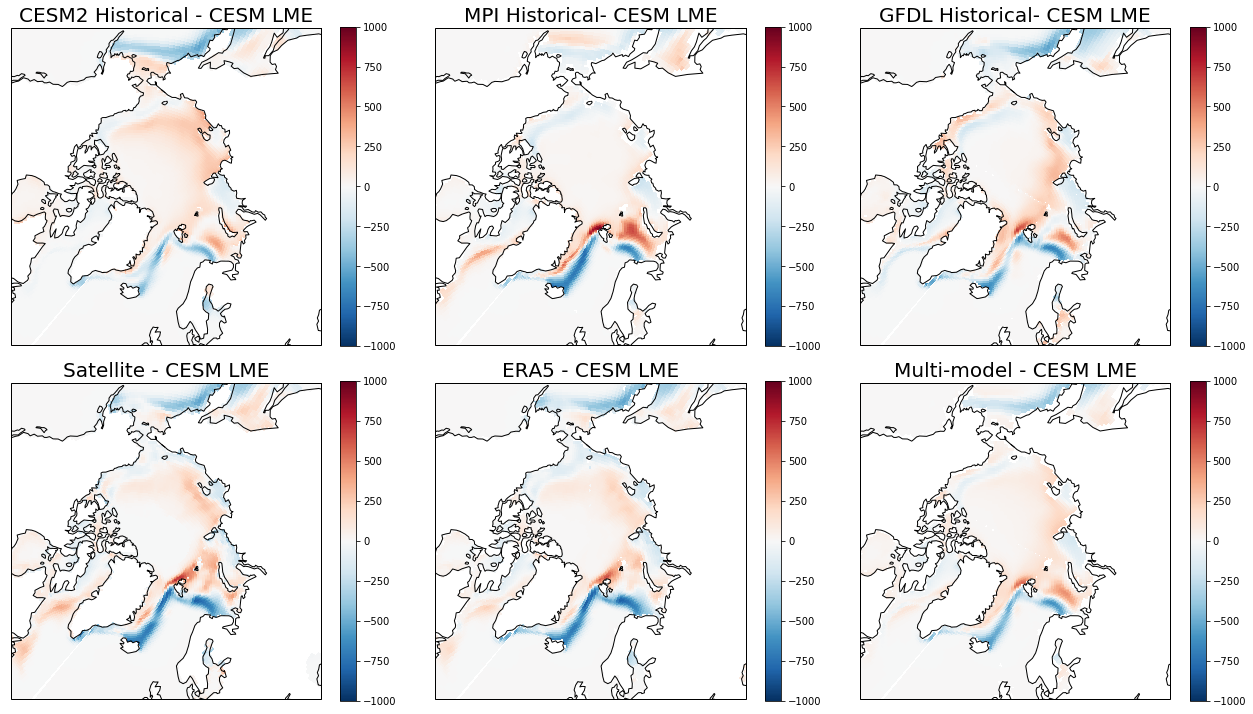

In [232]:
mnstates = [cesm2_hist_mnstate-train_mnstate, mpi_hist_mnstate-train_mnstate, gfdl_hist_mnstate-train_mnstate, 
            sat_mnstate-train_mnstate, era5_mnstate-train_mnstate, multimod_hist_mnstate-train_mnstate]
mnstate_titles = ['CESM2 Historical - CESM LME', 'MPI Historical- CESM LME', 'GFDL Historical- CESM LME', 
                  'Satellite - CESM LME', 'ERA5 - CESM LME', 'Multi-model - CESM LME']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(2,3,figsize=(18,10),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-1000,vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=20)
    
plt.tight_layout()

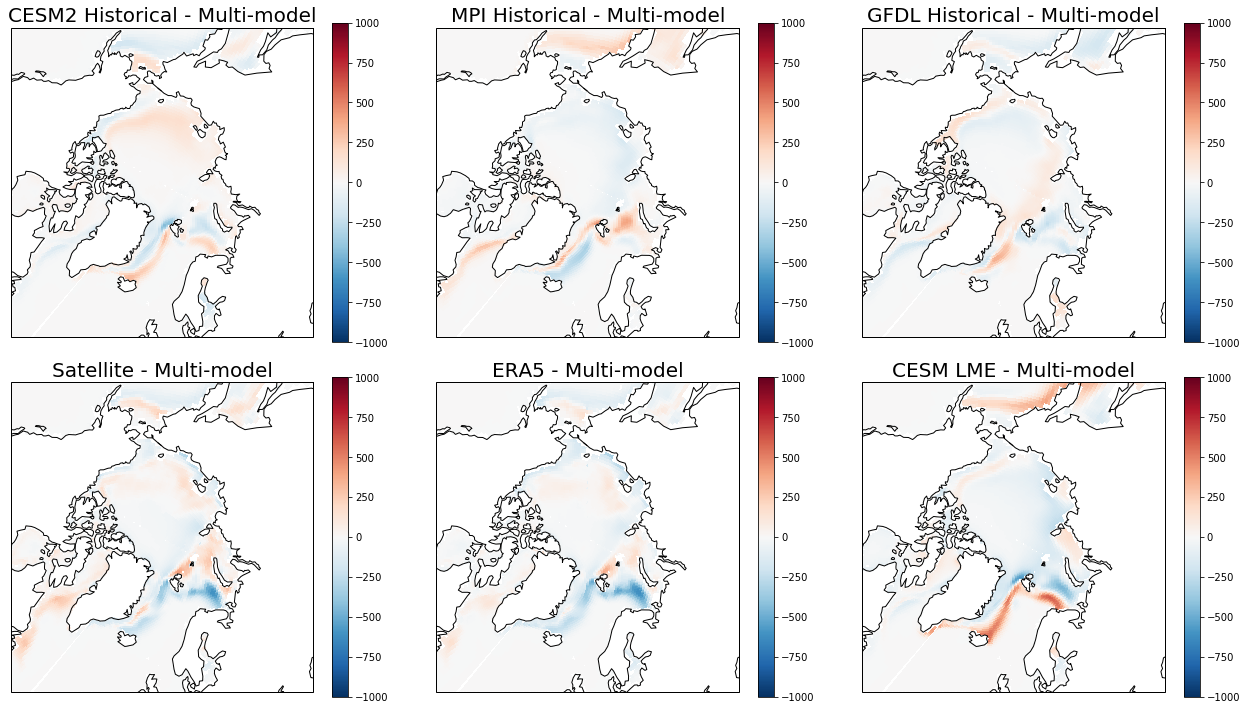

In [238]:
mnstates = [cesm2_hist_mnstate-multimod_hist_mnstate, mpi_hist_mnstate-multimod_hist_mnstate, gfdl_hist_mnstate-multimod_hist_mnstate,
            sat_mnstate-multimod_hist_mnstate, era5_mnstate-multimod_hist_mnstate, train_mnstate-multimod_hist_mnstate]
mnstate_titles = ['CESM2 Historical - Multi-model', 'MPI Historical - Multi-model', 'GFDL Historical - Multi-model', 
                  'Satellite - Multi-model', 'ERA5 - Multi-model', 'CESM LME - Multi-model']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(2,3,figsize=(18,10),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1000,vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=20)
    
plt.tight_layout()

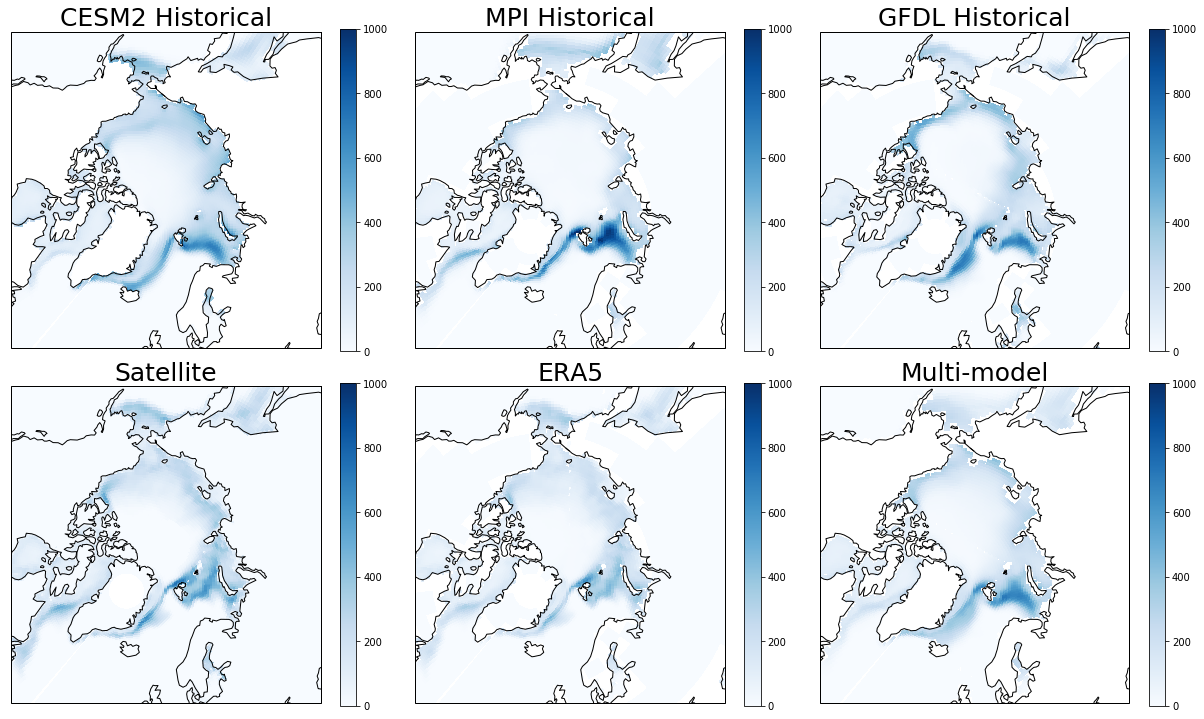

In [224]:
mnstates = [cesm2_hist_mnstate, mpi_hist_mnstate, gfdl_hist_mnstate, sat_mnstate, era5_mnstate, multimod_hist_mnstate]
mnstate_titles = ['CESM2 Historical', 'MPI Historical', 'GFDL Historical', 'Satellite', 'ERA5', 'Multi-model']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(2,3,figsize=(17,10),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='Blues', vmin=0, vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=25)
    
plt.tight_layout()

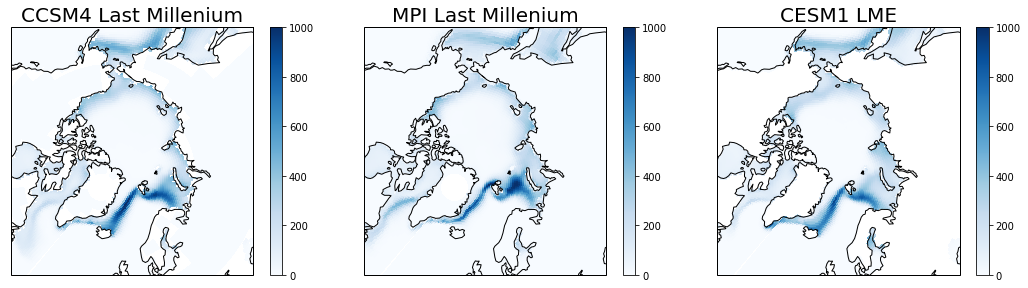

In [120]:
mnstates = [ccsm4_lm_mnstate, mpi_lm_mnstate, train_mnstate]
mnstate_titles = ['CCSM4 Last Millenium', 'MPI Last Millenium', 'CESM1 LME']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(1,3,figsize=(15,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='Blues', vmin=0, vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=20)
    
plt.tight_layout()

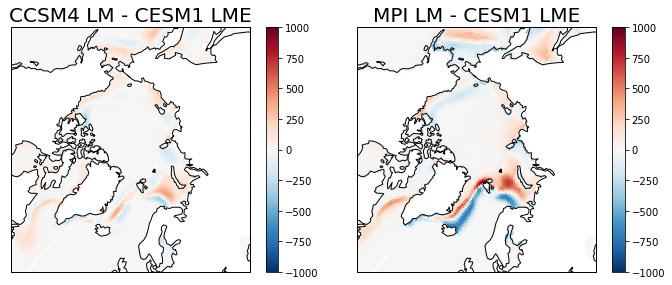

In [125]:
mnstates = [ccsm4_lm_mnstate - train_mnstate, mpi_lm_mnstate - train_mnstate]
mnstate_titles = ['CCSM4 LM - CESM1 LME', 'MPI LM - CESM1 LME']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(1,2,figsize=(10,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-1000,vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=20)
    
plt.tight_layout()

Text(0.5,1,'Variance: Satellite (1979-2016)')

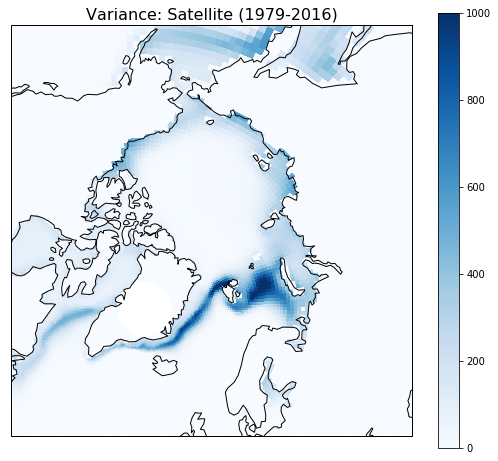

In [44]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_mpi_lm2['sic']['lon'], var_dict_mpi_lm2['sic']['lat'], 
                   mpi_lm_mnstate2, transform=ccrs.PlateCarree(), cmap='Blues', vmin=0,vmax=1000)
fig.colorbar(im)
plt.title('Variance: Satellite (1979-2016)', fontsize=16)

Text(0.5,1,'Variance: Satellite (1979-2016)')

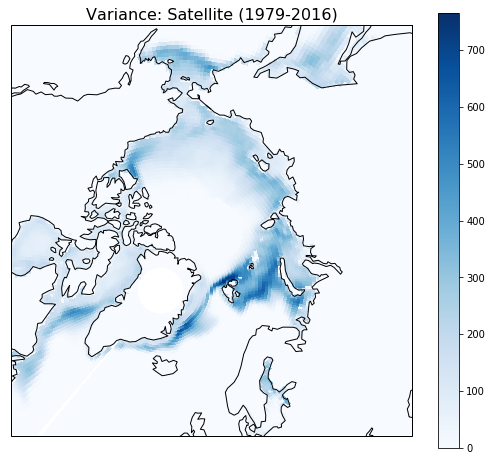

In [149]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
              sat_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: Satellite (1979-2016)', fontsize=16)

Text(0.5,1,'Variance Difference: \nCESM LME (850-1650) - Satellite (1979-2016)')

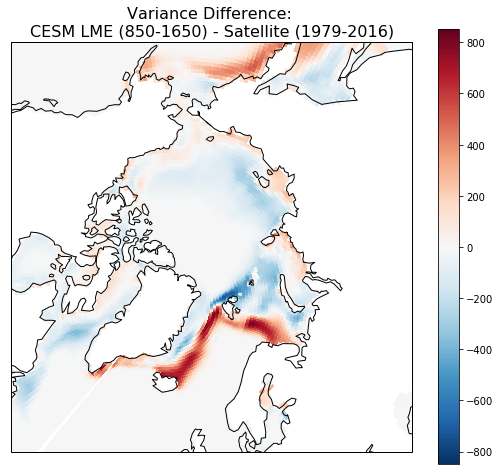

In [151]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    (train_mnstate-sat_mnstate), transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-850,vmax=850)
fig.colorbar(im)
plt.title('Variance Difference: \nCESM LME (850-1650) - Satellite (1979-2016)', fontsize=16)

Text(0.5,1,'Variance: CESM LME (850-1650)')

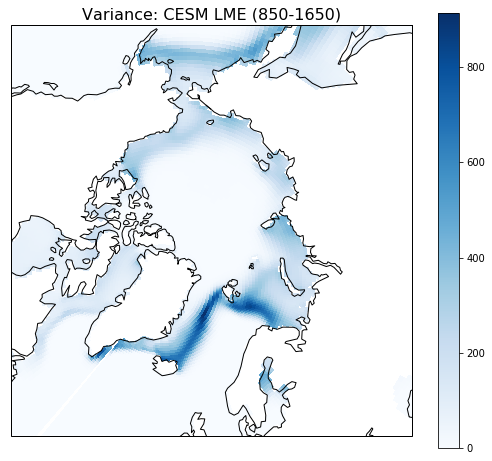

In [190]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
              train_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: CESM LME (850-1650)', fontsize=16)

Text(0.5,1,'Variance: CESM LE (2007-2100)')

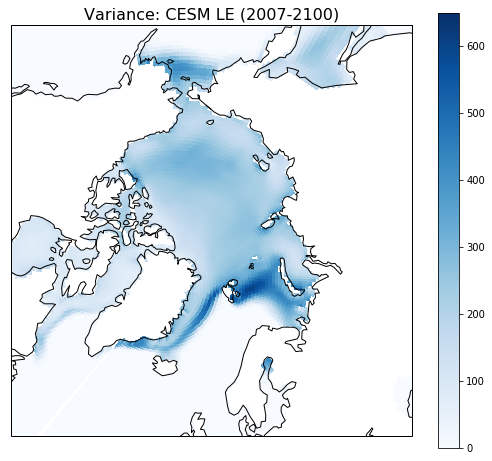

In [144]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    le_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: CESM LE (2007-2100)', fontsize=16)

In [221]:
train_mnstate.flatten()

(30720,)

Text(0.5,1,'Variance Difference: \nCESM LME (850-1650) - CESM LE (2007-2057)')

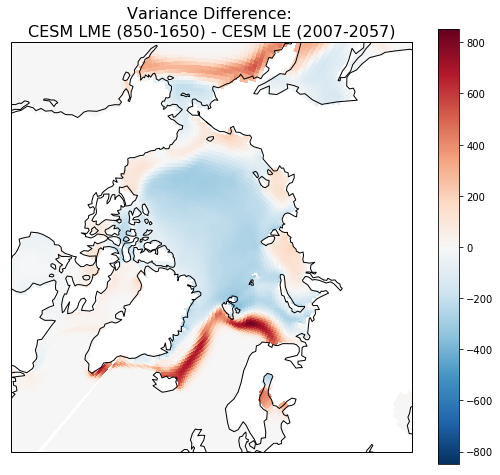

In [218]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    (train_mnstate-le_mnstate), transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-850,vmax=850)
fig.colorbar(im)
plt.title('Variance Difference: \nCESM LME (850-1650) - CESM LE (2007-2057)', fontsize=16)

In [224]:
scor_train_le = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_train_le

0.48215519742634216

Text(0.5,1,'Variance: CESM LME (1850-2005)')

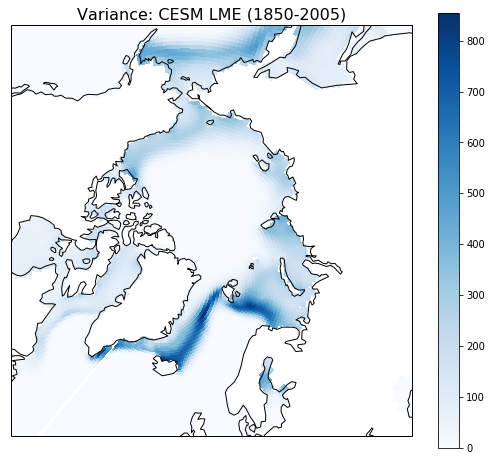

In [188]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    lme_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: CESM LME (1850-2005)', fontsize=16)

In [225]:
scor_train_lme = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(lme_mnstate.flatten()))[0,1]
scor_train_lme

0.9886389099677787

Text(0.5,1,'Variance Difference: \nCESM LME (850-1650) - CESM LME (1850-2005')

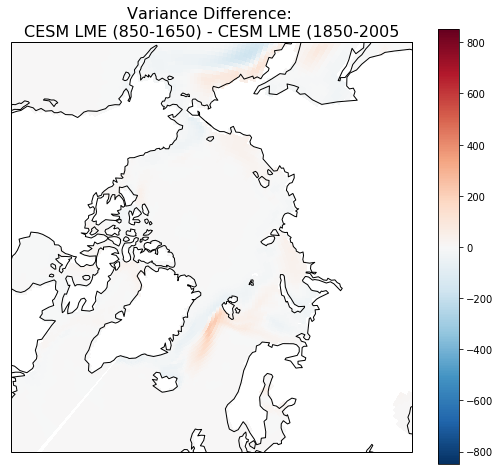

In [193]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    (train_mnstate-lme_mnstate), transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-850,vmax=850)
fig.colorbar(im)
plt.title('Variance Difference: \nCESM LME (850-1650) - CESM LME (1850-2005)', fontsize=16)

Text(0.5,1,'Variance: ERA5 (1980-2020)')

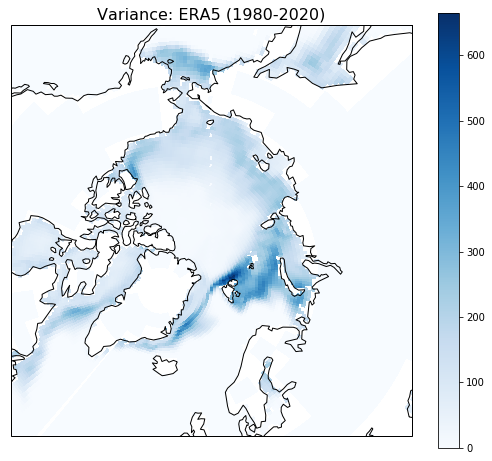

In [215]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'],
                    era5_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: ERA5 (1980-2020)', fontsize=16)

Text(0.5,1,'Variance Difference: \nCESM LME (850-1650) - Variance: ERA5 (1980-2020)')

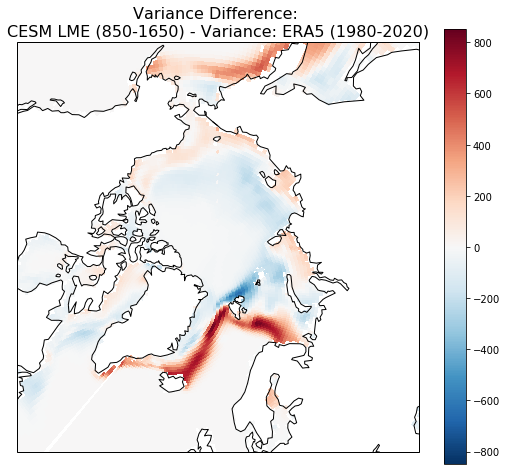

In [216]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    (train_mnstate-era5_mnstate), transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-850,vmax=850)
fig.colorbar(im)
plt.title('Variance Difference: \nCESM LME (850-1650) - Variance: ERA5 (1980-2020)', fontsize=16)

In [226]:
scor_train_era5 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
scor_train_era5

0.4622404964005686

NameError: name 'scor_train_lme' is not defined